# Gaussian Processes Workshop

In [1]:
!pip install -r requirements.txt > /dev/null  # quietly install everything.

In [2]:
# standard prelude (not the Haskell one)
import scipy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Intro

This is the supporting notebook for a short workshop on Gaussian Processes (GP), Bayesian Optimisation (BO). We'll focus on things a Data Scientist should know and use as part of their day-to-day work, with a few digressions into the maths along the way.

The workshop will consist of five sections:

- I. A not-too-technical overview of the ideas of GP/BO
- II. Use Case #1: GP as a model
- III. Use Case #2: BO for hyperparameter tuning
- IV. A deeper dive into how GP relates to other ideas in Data Science
- V. GP applied to Multi-Armed Bandits

# Toolkit

There are many Python frameworks and libraries for working with Gaussian Processes, here is a random selection: 

### Sklearn

In [3]:
import sklearn.gaussian_process as skl_gp

Scikit-learn has an entire [namespace](https://scikit-learn.org/stable/modules/gaussian_process.html) dedicated to Gaussian Processes, with sklearn's usual ML-centric focus on "Regression" and "Classification":

In [4]:
skl_gp.__all__  # module exports

['correlation_models',
 'regression_models',
 'GaussianProcessRegressor',
 'GaussianProcessClassifier',
 'kernels']

### GPyTorch

In [5]:
import gpytorch

Uber AI and Facebook's offering in this space is [GPyTorch](https://gpytorch.ai/), which
> [performs] all inference operations using modern numerical linear algebra techniques

### Bayesian Optimisation

In [6]:
import bayes_opt

The easiest library to find online when searching for BO

In [7]:
bayes_opt.__all__

['BayesianOptimization',
 'UtilityFunction',
 'Events',
 'ScreenLogger',
 'JSONLogger']

### GPyOpt

In [8]:
import GPy, GPyOpt

From [their](https://sheffieldml.github.io/GPy/) [websites](https://sheffieldml.github.io/GPyOpt/):
  > GPy is a Gaussian Process (GP) framework written in python
  
  > GPyOpt is a [...] library for Bayesian Optimization

### Hyperopt

In [9]:
import hyperopt  

From [their website](http://hyperopt.github.io/hyperopt/),
> Hyperopt has been designed to accommodate Bayesian optimization algorithms based on Gaussian processes and regression trees, but these are not currently implemented

I only include this because it's partially funded by D-Wave Systems, Inc., a quantum computing vendor with ties to big players like Google, NASA, Lockheed Martin, etc.

### and more!

Other Google search results include YELP's [MOE framework](https://github.com/Yelp/MOE), a non-commercially licensed collection of research algorithms ([Spearmint](https://github.com/HIPS/Spearmint)), a C++ implementation with a python wrapper ([BayesOpt](https://rmcantin.bitbucket.io/html/index.html)), ...

# I. The Big Ideas

Suppose I have an unknown (and possibly noisy) function $f(x)$. I have, or can draw, samples $(x_i, f(x_i))$ from this function.

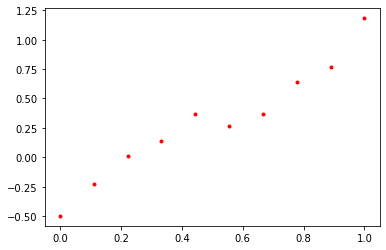

In [10]:
# I have a function
f = lambda x : (x**2 + np.random.normal(scale=0.2, size=1))

# I can draw samples
plt.plot(np.linspace(0,1,10), [f(x) for x in np.linspace(0,1,10)], ".", color="red")
plt.show()

Suppose I want an estimator $\hat{f}$ such that $\hat{f}(x) \approx f(x)$: Not an estimator of the value $f(x_i)$, an estimator of the function $f$ itself that I could use to interpolate / extrapolate $f(x)$ at new values of $x$.

Clearly, extrapolation is only possible if $\hat{f}$ is smooth(ish) and well-behaved in some sense. Important distinction: If $f$ isn't smooth(ish) and well-behaved the interpolation/extrapolation will be wrong; whereas if $\hat{f}$ isn't smooth(ish) and well-behaved the extrapolation isn't _possible_. Even if you think your unknown function $f$ has sharp, localized maxima, you might still be able to use GP if you think you can put a bound on how localised these maxima can be.

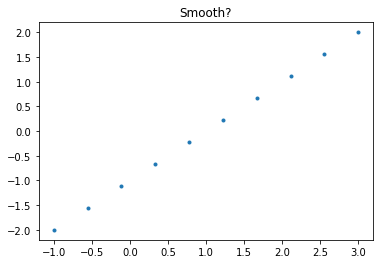

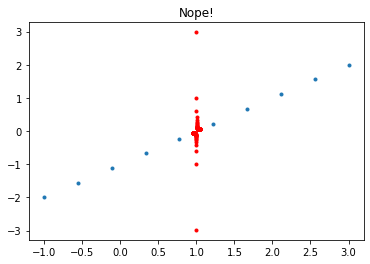

In [11]:
func = (lambda x: (x-1) + 0.001/(x-1))

x = np.linspace(-1,3,10)
plt.plot(x, func(x), ".")
plt.title("Smooth?")
plt.show()

plt.plot(x, func(x), ".")  # same as before
x = np.linspace(0.95,1.05,150)
plt.plot(x, func(x), ".", color="red")
plt.title("Nope!")
plt.show()

We will impose _Lipschitz Continuity_ , the condition that $\hat{f}$ have a finite derivative. This in turn means that neighboring points $\hat{f}(x)$ and $\hat{f}(x+dx)$, if we think of them as being stochastic, are correlated.

_Gaussian Processes_ are possibly the simplest way of solving this problem: just say each $\hat{f}(x)$ is normally distributed. The function estimator $\hat{f}$ is basically a multivariate normal: at each point $x$ the estimation is $\sim N(\mu, \sigma)$ for some $\mu, \sigma$. The correlations between neighboring points $\hat{f}(x)$ and $\hat{f}(x+dx)$ are then encoded in the covariance matrix of our multivariate normal distribution.

The only difficulty in this approach is that this is an (uncountably) infinitely multivariate normal, with a mean function and a covariance function instead of a mean vector and a covariance matrix. The covariance function is called a _Kernel_ , for reasons we will discuss in §IV.

A kernel function describes the correlation between two points. But correlation doesn't really care about which variable is which, they correlate _together_ , so kernels satisfy $K(x, y) = K(y, x)$. They also satisfy $K(x,x)=1$, since points are absolutey correlated with themselves, so it's OK to drop proportionality constants and specify kernels with "$\propto$" instead of "$=$".

Furthermore, while two neighbouring points are strongly correlated, two very distant points are (usually) weakly correlated. This means that Kernels are (usually) bell-curve-like. The exceptions to this are when correlations between distant points are significant, which betrays some underlying periodicity in the function $f$. If this reminds you of Fourier spectra, hold that thought for §IV.

In short, different kernels encode different ways for $\hat{f}$ to be smooth(ish) and well-behaved.

The reason GP is usually framed as a Bayesian technique is that an (uncountably) infinitely multivariate normal is just as easy to do Bayes Rule with as a finitely multivariate one, and so GPs are usually fit using Bayesian methods (choose a prior $\hat{f}_0$, put the data into the likelihood, compute the posterior $\hat{f}$). In principle, nothing stops a Bayesian from using the prior that's actually conjugate to their likelihood instead of a Gaussian. Similarly, nothing stops a non-Bayesian from not choosing a prior (i.e., choosing a flat prior).

# II. Use Case # 1: Use GP as a Model

## II.1 Competence before Comprehension

Before we go into the weeds, here's what fitting a GP to some data with sklearn looks like:

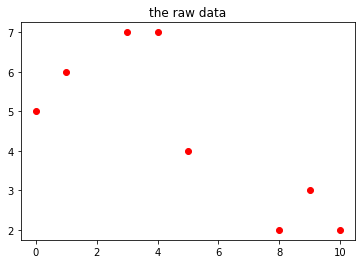

In [12]:
# stochastic process y(x)
data_x = [0,1,3,4,5,8,9,10]
data_X = np.array([[_] for _ in data_x])  # format required by Sklearn

data_y = [5,6,7,7,4,2,3,2]
plt.plot(data_x, data_y, 'o', color="red")
plt.title("the raw data")
plt.show()

In [13]:
def plot_GPR(gpr, title):
    """A utility for plotting a GP regressor on top of the data.
    `gpr` is a gaussian process regressor, already trained on / fit to some data."""
    plot_x = np.linspace(-2,12,150)
    y, ye = gpr.predict([[_] for  _ in plot_x], return_std=True)  # prediction returns mean an uncertainty
    plt.plot(plot_x, y, color="black")
    plt.fill_between(plot_x,y-ye, y+ye,color="cyan" )
    plt.plot(plot_x, y+ye, color="blue")
    plt.plot(plot_x, y-ye, color="blue")
    plt.plot(data_x, data_y, 'o', color="red")
    plt.title(title)
    plt.show()

Let's start by fitting an out-of-the-box GP to the data.

In [14]:
# Fit a GP to the data:
k = skl_gp.kernels.Matern()
r = skl_gp.GaussianProcessRegressor(kernel = k)
r.fit(X=data_X, y=data_y)
r.kernel_  # need the underscore to get the fitted values.

Matern(length_scale=2.16, nu=1.5)

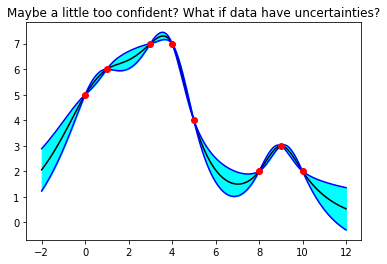

In [15]:
plot_GPR(r, "Maybe a little too confident? What if data have uncertainties?")

In [16]:
# Try a different kernel. What it is and how it works doesn't matter yet.
k2 = skl_gp.kernels.Sum(skl_gp.kernels.RationalQuadratic(length_scale_bounds=(0,5)),
                        skl_gp.kernels.WhiteKernel(noise_level_bounds=[0.01, 0.5]))
r2 = skl_gp.GaussianProcessRegressor(kernel = k2)
r2.fit(X=data_X, y=data_y)
r2.kernel_

RationalQuadratic(alpha=1.27, length_scale=4.47) + WhiteKernel(noise_level=0.5)

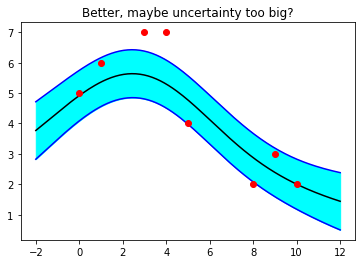

In [17]:
plot_GPR(r2, "Better, maybe uncertainty too big?")

In [18]:
# Try a different kernel. What it is and how it works doesn't matter yet.
k3 = skl_gp.kernels.Sum(skl_gp.kernels.RationalQuadratic(length_scale_bounds=(0, 5)),
                        skl_gp.kernels.WhiteKernel(noise_level_bounds=[0.01, 0.05]))
r3 = skl_gp.GaussianProcessRegressor(kernel = k3)
r3.fit(X=data_X, y=data_y)
r3.kernel_

RationalQuadratic(alpha=0.253, length_scale=1.19) + WhiteKernel(noise_level=0.05)

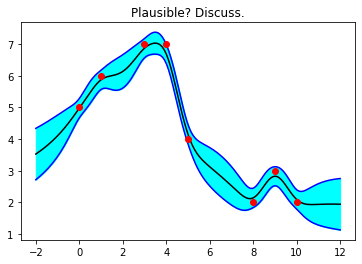

In [19]:
plot_GPR(r3, "Plausible? Discuss.")

To be clear: the uncertaintie bands tell us about the range of Gaussian Processes that we might be able to fit through these data. The GP is telling us what sorts of functions might fit the data.

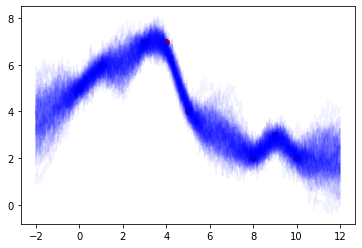

In [26]:
plot_x = np.linspace(-2,12,500)
y_samples = r3.sample_y([[x] for x in plot_x], 100, random_state=None)
plt.plot(data_X, data_y, 'o', color="red")
plt.plot(plot_x, y_samples, color="blue", alpha=0.05)
plt.show()

## II.2 Effects of Kernel properties on the fit

### II.2.1 Extrapolation and Interpolation

All of the models above have the same behaviour out-of-sample: they return to the prior $N(0,1)$ for any points that are too far from the data to be constrained.

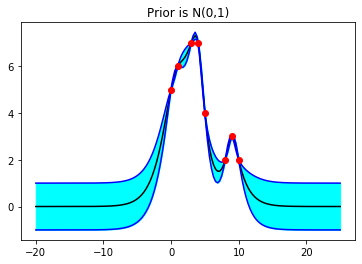

In [27]:
plot_x = np.linspace(-20,25, 150)
y, ye = r.predict([[_] for  _ in plot_x], return_std=True)
plt.plot(plot_x, y, color="black")
plt.fill_between(plot_x,y-ye, y+ye,color="cyan" )
plt.plot(plot_x, y+ye, color="blue")
plt.plot(plot_x, y-ye, color="blue")
plt.plot(data_x, data_y, 'o', color="red")
plt.title("Prior is N(0,1)")
plt.show()

But what if we used a periodic kernel like $K(x,y) = f({\rm sin}^2(x-y))$ ?

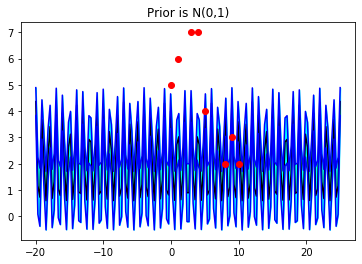

In [30]:
k4 = skl_gp.kernels.Sum(skl_gp.kernels.ExpSineSquared(length_scale_bounds=(0, 5), periodicity_bounds=[0,5]),
                        skl_gp.kernels.WhiteKernel(noise_level_bounds=[0.01, 0.25]))
r4 = skl_gp.GaussianProcessRegressor(kernel = k4)
r4.fit(X=data_X, y=data_y)

plot_x = np.linspace(-20, 25, 150)
y, ye = r4.predict([[_] for  _ in plot_x], return_std=True)
plt.plot(plot_x, y, color="black")
plt.fill_between(plot_x,y-ye, y+ye,color="cyan" )
plt.plot(plot_x, y+ye, color="blue")
plt.plot(plot_x, y-ye, color="blue")
plt.plot(data_x, data_y, 'o', color="red")
plt.title("Prior is N(0,1)")
plt.show()

If our correlation length scales are too small, we see the GP returning to the prior between points: with a low correlation length we're assuming the function can vary wildly, and without data to constrain parts of the function we haven't seen we're stuck with the prior!

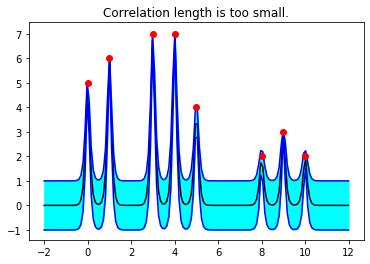

In [34]:
k5 = k = skl_gp.kernels.Matern(length_scale_bounds=(0.1, 0.11), nu=1.5)
r5 = skl_gp.GaussianProcessRegressor(kernel = k5)
r5.fit(X=data_X, y=data_y)
plot_GPR(r5, "Correlation length is too small.")

In reality, you'll sometimes have the option to de-mean and rescale your target variable data, so at least the prior won't be biased. Of course this is impossible if your data is streaming or if you're using GP for BO, since some of the data you'd want to determine your change of variables still lies in the future. You can still _guess_ at a sufficiently wide transform, but as always if you choose a prior that's too wide, your inference will suffer.

But if the correlation length is too big, the GP may be overconfident in its interpolations and extrapolations. This typically results in overconfident interpolations and extrapolations.

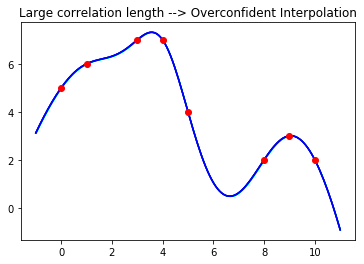

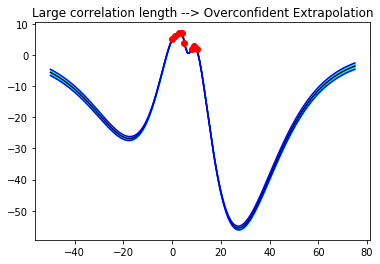

In [35]:
k6 = k = skl_gp.kernels.Matern(length_scale_bounds=(20, 20.1), nu=2.5)
r6 = skl_gp.GaussianProcessRegressor(kernel = k6)
r6.fit(X=data_X, y=data_y)
plot_x = np.linspace(-1, 11, 150)
y, ye = r6.predict([[_] for  _ in plot_x], return_std=True)

plt.plot(plot_x, y, color="black")
plt.fill_between(plot_x,y-ye, y+ye,color="cyan" )
plt.plot(plot_x, y+ye, color="blue")
plt.plot(plot_x, y-ye, color="blue")
plt.plot(data_x, data_y, 'o', color="red")
plt.title("Large correlation length --> Overconfident Interpolation")
plt.show()

plot_x = np.linspace(-50, 75, 150)
y, ye = r6.predict([[_] for  _ in plot_x], return_std=True)
plt.plot(plot_x, y, color="black")
plt.fill_between(plot_x,y-ye, y+ye,color="cyan" )
plt.plot(plot_x, y+ye, color="blue")
plt.plot(plot_x, y-ye, color="blue")
plt.plot(data_x, data_y, 'o', color="red")
plt.title("Large correlation length --> Overconfident Extrapolation")
plt.show()

### II.2.2 Choice of kernel family

#### Radial Basis Function

Any function for which $K(x,y) = K(\|x-y\|)$, with the $\ell_2$ norm.

The well-known Gaussian kernel $K(x,y) \propto e^{-\frac{\|x-y\|^2}{2\rho^2}}$, also known as Squared Exponential kernel, is an example from this family.

#### Matern

A neat function class, parameterised by $\nu$, which satisfies $K^{\nu} \otimes K^\nu = K^\nu$, or more explicitly

$$
k^\nu_{X\otimes Y}=[k^\nu_X \otimes k^\nu_Y]((x, y), (x^\prime, y^\prime)) = k^\nu_X(x,x^\prime)k^\nu_Y(y,y^\prime)
$$

The parameter $\nu$ tell us how smooth we want our fitting function to be (larger $\nu$ is smoother). Technically: $\nu$ says how often we want our function to be differentiable.

The squared exponential kernel is a Matern kernel with $\nu \to +\infty$. The Gaussian kernel results in functions $\hat{f}$ that are infinitely differentiable ($\in C^\infty$), aka smooth; stronger than our usual requirement that $\hat{f}$ be smooth(ish) ($\in C^n$).

The Matern kernels $K^\nu$ can even be written down explicitly in terms of modified Bessel Functions of the second kind $K_\nu$, as

$$
K^\nu(x, y) \propto \left(\frac{d}{\rho}\right)^\nu K_\nu\left(\sqrt{2\nu}\frac{d}{\rho}\right)
$$

where $d=d(x,y)$ is the metric distance between the two points and where $\rho > 0$ reduces to the standard deviation of the Gaussian kernel as $\nu \to \infty$. When the distance metric is chosen as the $\ell_2$ norm, Matern kernel is a radial basis function (which our previous talk of Bessel Functions should have hinted at).

In sklearn, call `kernel.Matern(length_scale=rho, nu=nu)`.

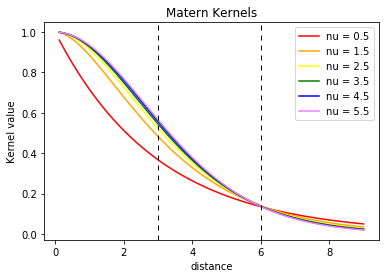

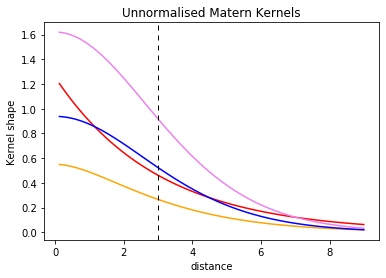

In [36]:
d = np.linspace(0, 9, 75)

Mat_unnorm = lambda v, rho, d : ((d/rho)**v)*scipy.special.kv(v, np.sqrt(2*v)*d/rho)

Mat = lambda v, rho, d : Mat_unnorm(v, rho, d) / Mat_unnorm(v, rho, 1e-7) # kernels satisfy K(0) = 1

plt.plot(d, Mat(0.5, 3, d), color="red")     # straight exponential
plt.plot(d, Mat(1.5, 3, d), color="orange")  # once differentiable
plt.plot(d, Mat(2.5, 3, d), color="yellow")  # twice differentiable
plt.plot(d, Mat(3.5, 3, d), color="green")
plt.plot(d, Mat(4.5, 3, d), color="blue")
plt.plot(d, Mat(5.5, 3, d), color="violet")
plt.axvline([3], linewidth=1, dashes=[5,5], color="black")
plt.axvline([6], linewidth=1, dashes=[5,5], color="black")
plt.title("Matern Kernels")
plt.xlabel("distance")
plt.ylabel("Kernel value")
plt.legend([f"nu = {i}.5" for i in range(6)])
plt.show()

plt.plot(d, Mat_unnorm(0.5, 3, d), color="red")     # straight exponential
plt.plot(d, Mat_unnorm(1.5, 3, d), color="orange")  # once differentiable
plt.plot(d, Mat_unnorm(4.5, 3, d), color="blue")
plt.plot(d, Mat_unnorm(5.5, 3, d), color="violet")
plt.axvline([3], linewidth=1, dashes=[5,5], color="black")
plt.title("Unnormalised Matern Kernels")
plt.xlabel("distance")
plt.ylabel("Kernel shape")
plt.show()

#### etc.

There are plenty of kernel families to choose from, you should try a few of them! You might want to check http://www.gaussianprocess.org/gpml/chapters/RW4.pdf
which also has a few examples of kernels over non-numeric functions.

## II.3 An example from HEP: Looking for a significant Excess/Deficit in model residuals

It depends on the model, but often we will expect normally-distributed residuals from our models. This is a natural place to use a Gaussian process!

Let's mock some data with a well-modeled background and a new effect:

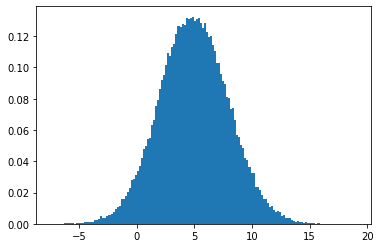

In [38]:
nA = 100000
nB = 2000
A = np.random.normal(loc=5, scale=3, size = nA)  # background
B = np.random.normal(loc=3, scale=1, size = nB)  # tiny excess!
sf = nA / (nA + nB)

C = np.concatenate([A, B])
h = np.histogram(C, bins=150, density=True)
centers = (h[1][:-1]+h[1][1:])/2
plt.bar(centers, h[0], width = (h[1][1:] - h[1][:-1]))

background_model_prediction = scipy.stats.norm(5,3).pdf(centers)
# plt.plot(centers, sf*background_model_prediction, color="black", dashes=[5,10])
plt.show()

In [39]:
residuals = (h[0] - (sf*background_model_prediction))/(sf*background_model_prediction)

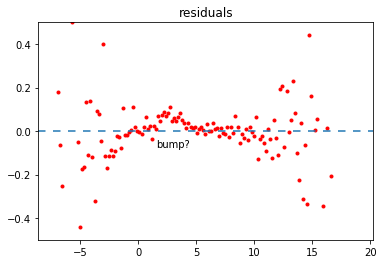

In [40]:
plt.plot(centers, residuals, '.', color='red')
plt.axhline(0, dashes=[5,5])
plt.text(1.5,-0.075,"bump?")
plt.ylim(-0.5,0.5)
plt.title("residuals")
plt.show()

In [41]:
k4 = skl_gp.kernels.Sum(skl_gp.kernels.RBF(length_scale_bounds=(1, 1)),
                        skl_gp.kernels.WhiteKernel(noise_level_bounds=[0.002, 0.002]))
resid_regress = skl_gp.GaussianProcessRegressor(kernel = k4)
resid_regress.fit([[c] for c in centers], residuals)
resid_regress.kernel_

RBF(length_scale=1) + WhiteKernel(noise_level=0.002)

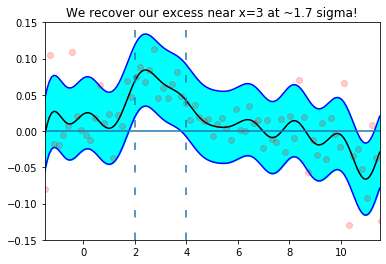

In [42]:
plot_x = np.linspace(-1.5, 11.5, 150)
y, ye = resid_regress.predict([[_] for  _ in plot_x], return_std=True)
plt.plot(plot_x, y, color="black")

sig = np.max(y/ye)  # look for the biggest excess in the residuals
plt.fill_between(plot_x,y-ye, y+ye,color="cyan")
plt.plot(plot_x, y+ye, color="blue")
plt.plot(plot_x, y-ye, color="blue")
plt.plot(centers, residuals, 'o', color="red", alpha=0.2)
plt.axhline(0)
plt.axvline(2, dashes=[5,10])
plt.axvline(4, dashes=[5,10])
plt.xlim(-1.5,11.5)
plt.ylim(-0.15,0.15)
plt.title(f"We recover our excess near x=3 at ~{sig:.1f} sigma!")
plt.show()

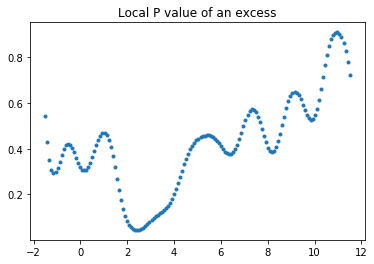

In [43]:
sigs = y/ye
pvals = scipy.stats.norm.sf(sigs,0,1)
plt.plot(plot_x, pvals, '.')
plt.title("Local P value of an excess")
plt.show()

This GP fit to the _fractional_ residuals says there's definitely something worth investigating where we placed our signal events, but also finds spurious signals in the tails of our distribution (because of Poisson statistical fluctuations). Also, let's not confuse this GP band with the frequentist statistical significance: there are multiple comparisons (as many comparisons as there are points on the function domain) and the band itself is highly dependent on the choice of kernel.

# III. Use Case #2: Use BO for model tuning

At the end of the last section, we saw a function describing the local $p$-value of a Gaussian Process over its domain. The idea that some feature of a Gaussian process can be encapsulated into a function is at the heart of Bayesian Optimisation: that function becomes the objective function that we are attempting to optimise.

_Optimal Bayesian Experimental Design_ looks for the way to extract the most information out of the least number of evaluations of the function. The objective function is the width of the uncertainty band of the GP: the best experiment would be to sample wherever the uncertainty is highest.

Bayesian function optimisation, and more practically _Optimal Bayesian Model Tuning_ , looks for the parameter or hyperparameter that improves a function the most, out of the least number of evaluations of the function. For model tuning, this function might be the accuracy or precision or recall on a fixed dataset, as a function of the model parameters. The objective function is the upper credible bound of the GP: the best experiment, following the "optimism-under-uncertainty" dogma, would be to check the parameter with the best possible potential model improvement. If this reminds you of the UCB bandit algorithm, hold that tought for §V.

## III.1 BO for finding the optimum of an expensive function (by hand)

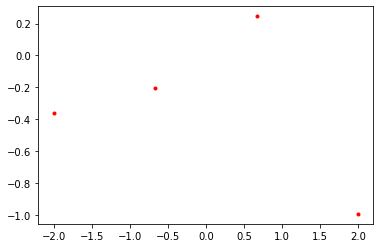

In [71]:
# Have function, can sample

samples = np.empty(shape=(2,100))  # limit on the amount of exploring we can do
i = 0

def expensive_sample(x):
    global samples, i
    f = lambda x: (0.05 - 0.2*x**2 + np.random.normal(scale=0.4))
    samples[0, i] = x
    samples[1, i] = f(x)
    i += 1
    return None

def loc():
    return samples[0,:i]

def val():
    return samples[1,:i]

# Preliminary exploration

x = np.linspace(-2,2,4)

for xi in x:
    expensive_sample(xi)  # ouch
    
plt.plot(loc(), val(), '.', color='red')
plt.show()

Let's start very slowly and do the first few iterations of BO by hand:

In [84]:
# Evaluate this cell over and over to manually run each iteration of BO.

kernel = skl_gp.kernels.Sum(skl_gp.kernels.Matern(), skl_gp.kernels.WhiteKernel(noise_level_bounds=[0.45, 0.45]))
r = skl_gp.GaussianProcessRegressor(kernel = kernel)
r.fit(X=loc().reshape(-1,1), y=val())

plot_x = np.linspace(-3,3,75)
y, ye = r.predict(plot_x.reshape(-1,1), return_std=True)

plt.plot(plot_x, y, color="black")
plt.fill_between(plot_x,y-ye, y+ye,color="cyan" )
plt.plot(plot_x, y+ye, color="blue")
plt.plot(plot_x, y-ye, color="blue")
plt.plot(loc(), val(), '.', color='red')
plt.show()

objective = y + ye
next_val = np.max(objective)
next_loc = plot_x[np.argmax(objective)]

plt.plot(plot_x, objective)
plt.scatter(next_loc, next_val)
plt.show()

expensive_sample(next_loc)  # ouch

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

## III.2 BO for tuning linear regression (by hand)

Let's use BO (instead of Gradient Descent) to fit a linear regression. The "truth" is $y = 0.2 x - 0.4$, or $m=0.2$ and $b = -0.4$

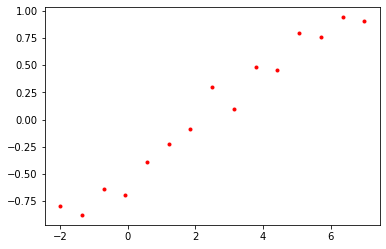

In [85]:
x_data = np.linspace(-2,7,15)
y_data = 0.2 * x_data  - 0.4 + np.random.normal(scale=0.15, size=15)

plt.plot(x_data, y_data, ".", color="red")
plt.show()

In [86]:
def predict(m,b):
    return m * x_data + b

def residuals(m,b):
    return y_data - predict(m, b)

def badness(m,b):
    return np.sum(residuals(m,b)**2) / 500  # rescale so that N(0,1) is a sensible prior.

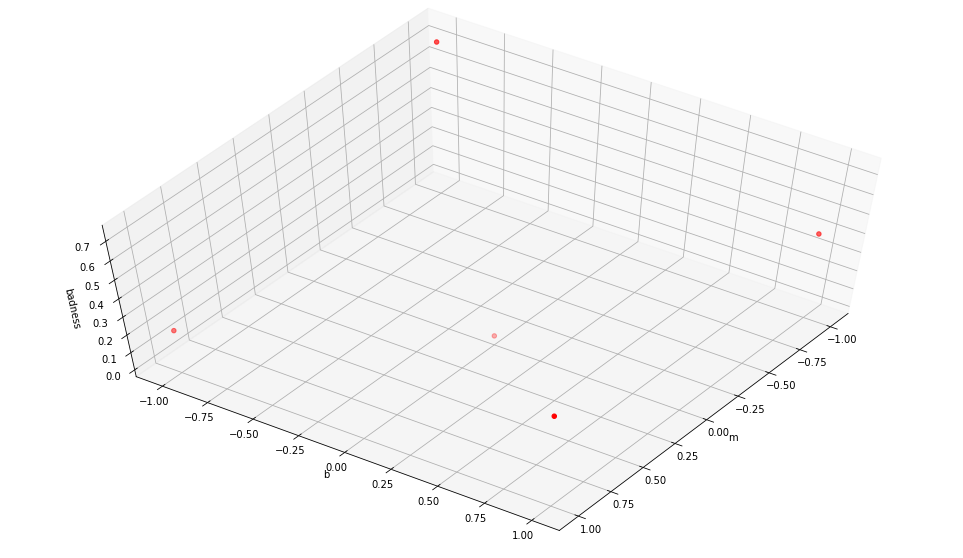

In [87]:
# Have function, can sample

samples = np.empty(shape=(3,100))  # limit on the amount of exploring we can do
i = 0

def expensive_sample(m, b):
    global samples, i
    samples[0, i] = m
    samples[1, i] = b
    samples[2, i] = badness(m, b)
    i += 1
    return None

def loc():
    return samples[0:2,:i]

def val():
    return samples[2,:i]

# Preliminary exploration

for m, b in zip([-1,-1,1,1,0] , [-1,1,-1,1,0]):
    expensive_sample(m,b)

fig = plt.figure(figsize=(17,10))
ax = plt.axes(projection='3d')
ax.view_init(60, 35)
ax.scatter3D(loc()[0], loc()[1], val(), color="red");
ax.set_xlabel('m')
ax.set_ylabel('b')
ax.set_zlabel('badness');

plt.show()

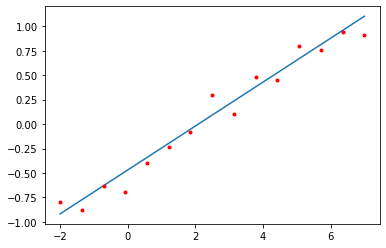

next iteration: (0.020408163265306145, 0.46938775510204067) 21


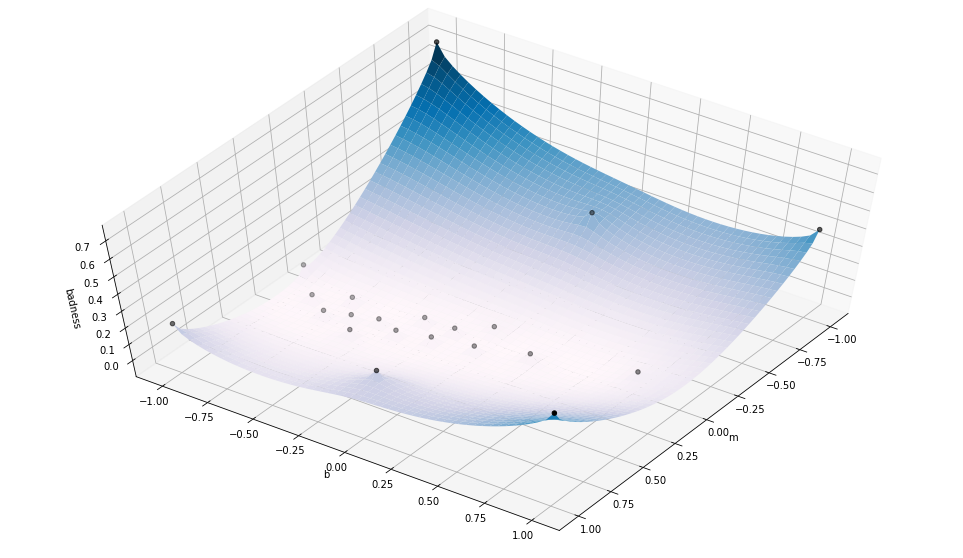

In [104]:
# Evaluate this cell over and over to manually run each iteration of BO.

plt.plot(x_data, predict(*loc()[0:2][:,np.argmin(val())]))  # best found so far
plt.plot(x_data, y_data, ".", color="red")
plt.show()

kernel = skl_gp.kernels.Matern(length_scale=0.1, nu=0.5)
r = skl_gp.GaussianProcessRegressor(kernel = kernel)
r.fit(X=loc().T, y=val())

m = np.linspace(-1, 1, 50)
b = np.linspace(-1, 1, 50)
M , B = np.meshgrid(m, b)
grid = list(zip(np.ndarray.flatten(M), np.ndarray.flatten(B)))
y, ye = r.predict(grid, return_std=True)
Z = y.reshape(50,50)
Ze = ye.reshape(50,50)

next_val = np.min(y-ye)
next_mb = grid[np.argmin(y-ye)]
print("next iteration:", next_mb, i)

fig = plt.figure(figsize=(17,10))
ax = plt.axes(projection='3d')
ax.view_init(60, 35)

ax.plot_surface(M, B, Z-Ze, cmap='PuBu', edgecolor='none')

ax.scatter3D(loc()[0], loc()[1], val(), color="black");
ax.set_xlabel('m')
ax.set_ylabel('b')
ax.set_zlabel('badness');

plt.show()

expensive_sample(*next_mb)  # ouch

## III.2 An example from ML engineering: Hyperparameter tuning

In [ ]:
# TODO

# IV. The Bigger Picture

## IV.1 Reproducing Kernel Hilbert Spaces (RKHS)

This topic is denoted as "quite technical" in Elements of Statistical Learning (§5.8 therein).

Recall that a [Hilbert space](https://en.wikipedia.org/wiki/Hilbert_space) is a bunch of vectors (or functions) with an inner product $\langle \cdot, \cdot \rangle$ and is nonpathological enough to use metric geometry and calculus (i.e. it is a metric space and a Cauchy space). Recall that the metric in a Hilbert space is induced from the $\ell^2$ distances $\|u-v\| = \sqrt{\langle u-v, v-u \rangle}$ between elements $u,v \in \mathcal{H}$.


Definition (see also [wikipedia](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space)): A _Reproducing Kernel Hilbert space_ is
- a Hilbert space of functions $X \to \mathbb{R}$, in which
- if two functions $f$ and $g$ in the RKHS are close in norm, then they are also pointwise close, i.e. $$
\|f-g\| < \epsilon \implies \exists \delta : \forall x \in X ,|f(x)-g(x)| < \delta.
$$

You should recognise the $(\epsilon,\delta)$ definition of continuity: RKHSs are Hilbert spaces that are "continuous". In fact, these spaces are smoother than that: RKHS are to Hilbert spaces what [Lipshitz continuous functions](https://en.wikipedia.org/wiki/Lipschitz_continuity) are to functions.

The Reproducing Kernel $K(x,y)$ of any RKHS is unique. The kernel is symmetric $K(x,y) = K(y,x)$, positive $K(x,y) \ge 0$, and satisfies the eponymous property known as _reproducing_. Let us write $K_x(y) \in \mathcal{H}$ the partial application of K, then

$$
\forall f \in \mathcal{H}, \forall x \in X,\, \exists K_x : f(x) = \langle f, K_x \rangle
$$

Basically: the Kernel of a RKHS encapsulates into an easy function $K: X\times X \to \mathbb{R}$ the nonlocal information you'd usually think of as involving the difficult inner-product integral $\langle \cdot,\cdot\rangle : \mathcal{H} \times \mathcal{H} \to \mathbb{R}$.

### Examples

#### Fourier Transforms

In n dimensions, Fourier transforms have kernel $\mathcal{F}(x, k) = (2\pi)^{n/2} \exp\left(-i \langle k, x\rangle\right)$.

The fourier transform of $f(x)$ is then simply $$
\tilde{f}(k) = \langle f, \mathcal{F}_k \rangle = (2\pi)^{n/2} \int f(x) \exp\left(-i \langle k, x\rangle\right)dx
$$

#### Kernelised Linear Regression

When we write linear regression as $\hat{y}=x^T \beta + \epsilon$, we have $f(x) = x^T \beta = \langle \beta , K_x \rangle$. The coefficients $\beta$ completely determine the function $f$ being fit. The kernel is quite simply $K(x,y) = \langle x, y\rangle$, anything involving the regularisation lives in the parameters $\beta$ being regularised.

#### Green's Functions

Let $K$ be the kernel of some integral operator (which you'd usually solve with an inner product). Let $L$ be some linear differential operator.

If $L\,K(x,y) = \delta(x-y)$ then $k$ is actually the kernel of $L^{-1}$, i.e. $K$ is the Green's function of $L$. Indeed,

$$
(LL^{-1}) = \left( L \int [K(x,y) \times \cdots] dy \right) = \left( \int L[K(x,y)\times \cdots] dy \right) = \left(\int \delta(x-y) \cdots dy \right) = \mathbb{I}{\rm d}
$$
where to proceed in each step we use our ansatz for the of the inverse, the Leibniz integral rule (assuming contant integration limits), and the resolution of the identity operator. The easiest way to solve a differential equation is then to consult [a standard table of Green's functions](https://en.wikipedia.org/wiki/Green%27s_function#Finding_Green's_functions).

- To solve the Poisson Equation $\nabla^2 \phi(x) = \rho(x)$ sourced by $\rho(x)$, use the Green's function $\nabla^2 G(x,y) = \delta(x-y)$. The Newton Kernel in 3D is $G(x,y) = - \frac{1}{4\pi}\frac{1}{\|x-y\|}$, so that

$$
\phi(x) = \langle \rho , G_x \rangle = -\frac{1}{4\pi}\int \frac{\rho(y)}{\|x-y\|} dy
$$

- To solve the Diffusion Equation $(\partial_t - k \partial_x^2)\; \Theta (x,t) = W(x,t)$ sourced by $W(x,t)$, use the Green's function $(\partial_t - k \partial_x^2) G(x, t; x^\prime, t^\prime) = \delta(t-t^\prime) \delta(x-x^\prime)$. The kernel for the heat equation in 1D is $G(x, t; x^\prime, t^\prime)=\frac{1}{\sqrt{4\pi k |t-t^\prime|}} \exp \left(-\frac{|x-x^\prime|^2}{4 k |t-t^\prime|} \right)$, so that

$$
\Theta(x,t) = \langle W, G_{x,t} \rangle = \int W(x^\prime,t^\prime) G(x, t; x^\prime,t^\prime) dx^\prime dt^\prime
$$

- Green's functions also show up in QFT as _propagators_ : they correlate events across spacetime when you integrate "over all possible histories".

#### Dual Space

Each Hilbert space $\mathcal{H}$ has an inner product $\langle x,y\rangle_\mathcal{H}$, which serves as the Kernel $K(x,y) = \langle x,y\rangle_\mathcal{H}$ of a RKHS. This RKHS happens to be $\mathcal{H}$'s [Dual Space].(https://en.wikipedia.org/wiki/Hilbert_space#Duality)

The notion of a dual space underlies the entire theory of Fourier transforms, where $f(x)$ and $\tilde{f}(k)$ are duals.

It also is important in Quantum Mechanical [Dirac Notation](https://en.wikipedia.org/wiki/Bra%E2%80%93ket_notation), where expressions like $\psi(x) = \langle x | \psi \rangle$ are actually the dualised version of $\psi(x) = \langle \psi , K_x\rangle$. In QM, the Kernel of the position representation (expressed in the position representation) is $K(x,y) = \delta(x-y)$, the "Kernel" $k$ of the momentum representation (expressed in the position representation) is the kernel $e^{ikx}$ of the Fourier Transform, and various other kernels exist for arcane phase space representations. A great book this area is one of my personal favorites, Eduard Prugovecki's _Stochastic Quantum Mechanics and Quantum Spacetime_.


## IV.2 The "Kernel Trick"

### IV.2.1 What is the Kernel Trick?

Problem: Linear functions are often too simple to provide good estimators

Solution: Map to a higher dimensional feature space via $\Phi : x \to \Phi(x)$ and
solve the problem there. i.e. replace every $x$ by $\Phi(x)$ in your algorithm.

New Problem: $\Phi(x)$ is difficult to compute

Solution: Sometimes you don't need $\Phi(x)$, you only need $\langle \Phi(x), \Phi(y)\rangle$. In that case, instead of computing $\Phi(x)$ and $\Phi(y)$ explicitly, use a kernel function $K(x, y) = \langle \Phi(x), \Phi(y)\rangle$ to compute the inner product _without solving the integral_.

https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space#Feature_maps

https://en.wikipedia.org/wiki/Kernel_method

### IV.2.2 Kernel Ridge Regression

This is what we've been building up to for the last few sections, don't give up now!

The kernel of kernel regression is quite simply $K(x_i,x_j) = \langle x_i, x_j\rangle \sim K_{i,j}$, so we can use the kernel trick to formally represent all the feature engineering we might want to do, e.g. $\Phi(x_1, x_2) = (x_1, x_1^2/5, x_1 x_2, \ln(x_1))$. Then we simply have $f(x) = \langle \alpha , K_x \rangle$, where $K$ is now the kernel of the feature-mapped space. The weights vector

$$
\alpha = (K_{i,j} + \lambda \delta_{i,j})^{-1} y
$$

now contains all of the regularisation details (the Tikhonov matrix $\lambda \delta_{i,j}$) as well as the promotion $\langle x_i, x_j\rangle \mapsto K_{i,j} = \langle \Phi(x_i), \Phi(x_j) \rangle$. The penalty term of Kernel ridge regression is $+\lambda (\alpha^T K \alpha)$.

The kernel $K_{i,j}$ (the Gram matrix of all possible inner products $\langle \Phi(x_i), \Phi(x_j) \rangle$) of Kernel Ridge regression is the same as the kernel $K(x_i, x_j)$ (covariance function) of the Gaussian Process we used as the prior. This has two really cool consequences:

1. Gaussian Process Regression is the same thing as Kernel Ridge Regression (just like Bayesian Linear Regression with a Gaussian prior is the same as Ridge Regression). So, we can use feature maps and the Kernel Trick with Gaussian Processes too! We just need to rethink our Kernel if we do.


2. Recall that we are free, as Bayesians, to choose _any prior we want_ :
      - If the likelihood calls for a Gaussian conjugate prior, we're very happy. Just remember to rescale everything with $\Phi$ so that the GP prior of N(0,1) is not too informative / biased for your analysis.
      - If the likelihood calls for a non-Gaussian but still closed-form conjugate prior, we're effectively using some other kind of regularised kernel regression.
      - If the likelihood doesn't call for a closed-form conjugate prior, we can try to use feature mappings $\Phi$ to turn it into one that does.


# V. GP-UCB

An approach to infinite-armed and/or contextual bandits. GPUCB attempts to Bayes-Optimise the unknown rewards function $(a \otimes x) \mapsto r$, where there are an infinite number of arms $a$ and an infinite number of possible context values $x$.

Some homework:

- https://arxiv.org/pdf/1705.06808.pdf
- https://arxiv.org/pdf/1704.00445.pdf
- https://arxiv.org/pdf/1603.06288.pdf
- https://arxiv.org/pdf/1309.6869.pdf
- https://arxiv.org/pdf/0912.3995.pdf

# References and Useful Links

- http://www.gaussianprocess.org/gpml/chapters/RW.pdf